In [246]:
# Data taken from
# https://survstat.rki.de/Content/Query/Create.aspx

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("campylobacter_data.csv", encoding="utf-16", sep="\s+")
df = df.drop(columns=["Total", "Unnamed: 0"])
df = df.drop(index=df.index[0])
df.values.flatten().tolist()
campy = [x for x in df.values.flatten().tolist() if pd.notna(x)]

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_5032/4223274364.py:8: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv("Data.csv", encoding="utf-16" , sep="\s+")


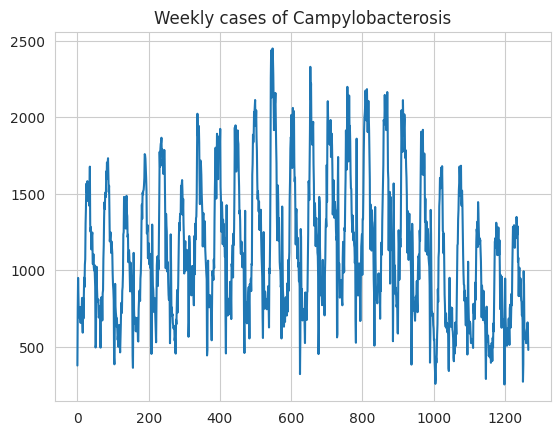

In [247]:
plt.plot(campy)
plt.title("Weekly cases of Campylobacterosis")
plt.show()

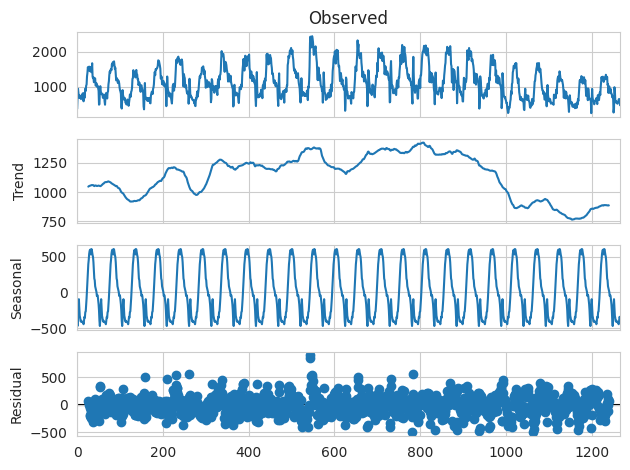

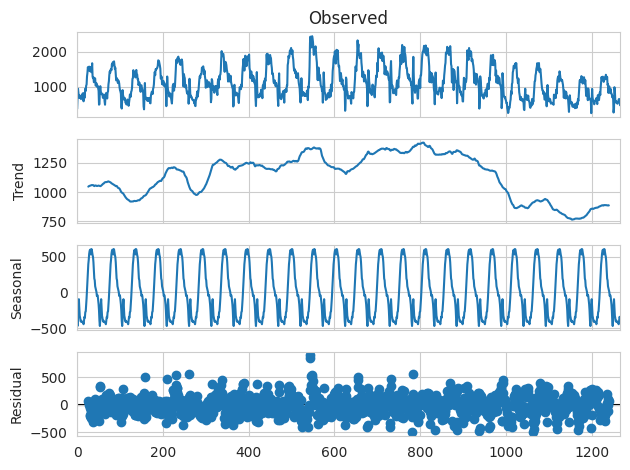

In [235]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(campy, period=52)

decomp.plot()

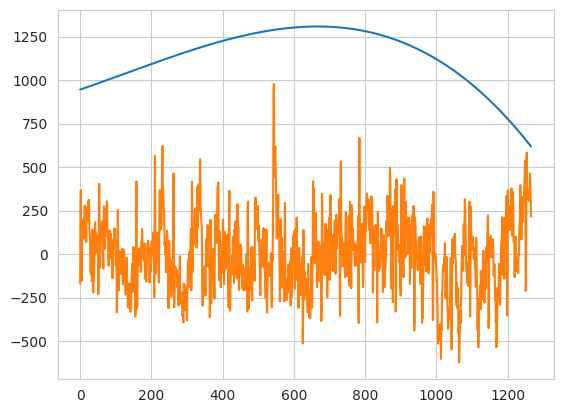

In [236]:
trend_coeffs = np.polyfit(range(len(campy)), campy, 3)
trend_line = np.polyval(trend_coeffs, range(len(campy)))

plt.plot(trend_line)
campy_clean = campy - decomp.seasonal - trend_line
plt.plot(campy_clean)
plt.show()

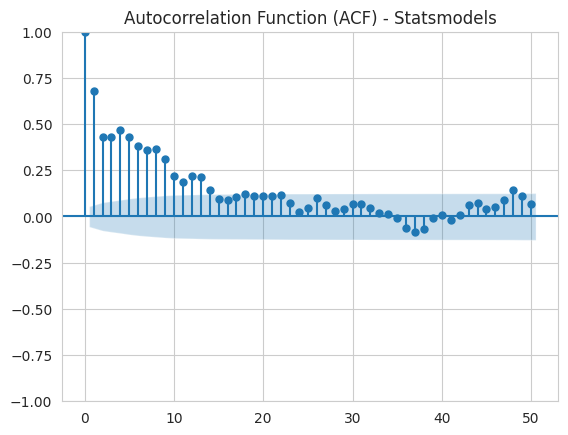

In [237]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

# Plot the autocorrelation function using statsmodels
plot_acf(campy_clean, lags=50)
plt.title("Autocorrelation Function (ACF) - Statsmodels")
plt.show()

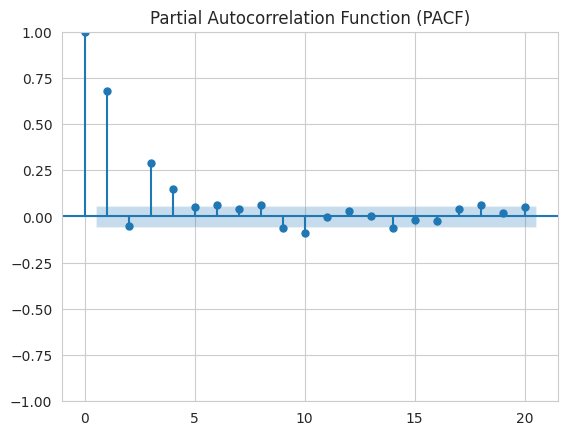

In [238]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plot the partial autocorrelation function
plot_pacf(campy_clean, lags=20, method='ywmle')
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()

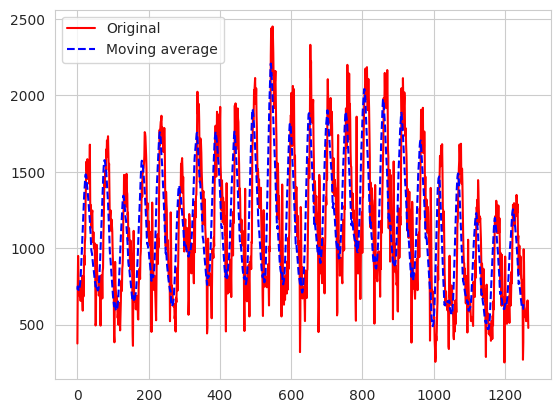

In [260]:
ma10 = np.convolve(campy, np.ones(14)/14, mode='valid')
plt.plot(campy, "r", label="Original")
plt.plot(ma10, "b--", label="Moving average")
plt.legend(loc="upper left")
plt.show()

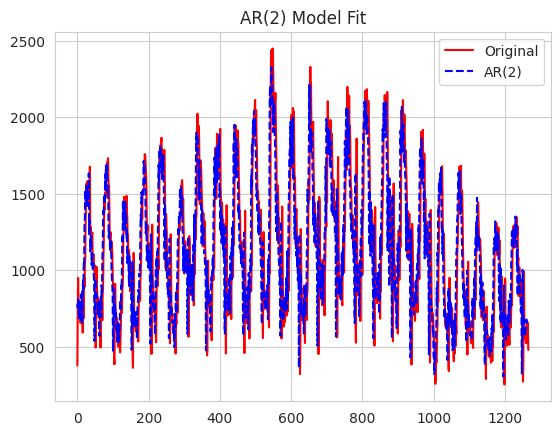

In [261]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(campy, lags=4, old_names=False)
results = model.fit()

plt.plot(campy, "r", label="Original")
plt.plot(results.fittedvalues, "b--", label="AR(2)")
plt.legend()
plt.title("AR(2) Model Fit")
plt.show()

/home/anza/PyCharmMiscProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


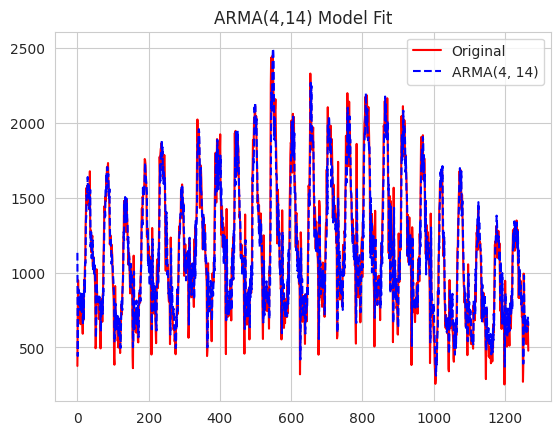

In [269]:
import statsmodels.tsa.arima.model as ARIMA

model = ARIMA.ARIMA(campy, order=(4, 0, 14))
results = model.fit()

plt.plot(campy, "r", label="Original")
plt.plot(results.fittedvalues, "b--", label="ARMA(4, 14)")
plt.legend()
plt.title("ARMA(4,14) Model Fit")
plt.show()

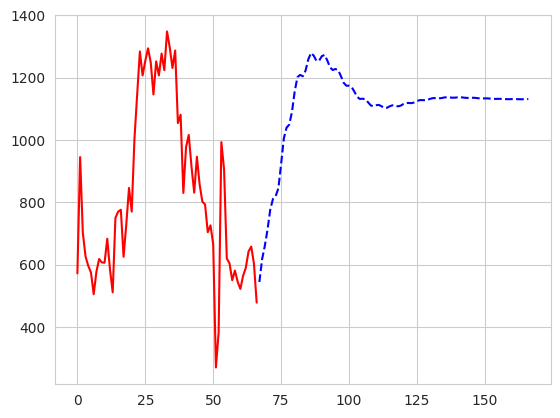

In [270]:
forcast_data = results.forecast(100)

a = len(campy[1200:])
b = len(forcast_data)

plt.plot(range(a), campy[1200:], "r", label="Original")
plt.plot(range(a, a+b), forcast_data, "b--", label="Forecast")
plt.show()
